In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import h5py
from pathlib import Path
from tqdm import tqdm
from scipy.signal import convolve2d, convolve

In [2]:
BASE_DIR = Path("/home/roblesee/dune/hpst/data/sim_data/train")
NUMU_DIRECTORY = BASE_DIR / "argon_cubic_production"
NUE_DIRECTORY = BASE_DIR / "argon_cubic_production"

numu_files = list(NUMU_DIRECTORY.glob("argon_cubic_numu_production_*.h5"))
nue_files = list(NUE_DIRECTORY.glob("argon_cubic_nue_production_*.h5"))

In [3]:
class_names = {
    "Other": np.inf,
    "Electron": 11,
    "Muon": 13,
    "Proton": 2212,
    "Neutron": 2112,
    "Charged Pion": 211,
    "Neutral Pion": 111,
    "Charged Kaon": 321,
    #"Photon": 22
}

class_ids = np.asarray(list(class_names.values()))

In [4]:
def plot_sample(eid):
    mask = evtid == eid
    #print(np.unique(pdgs[mask][classes[mask] == 0]))
    #mask &= edep > 0.05
    targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#000000", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b', '#e377c2'], N=9)
    scale = 10
    #fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(scale*5,scale*5))
    #coord_range_z = coords[mask, 2].min(), coords[mask, 2].max()
    #coord_range_x = coords[mask, 0].min(), coords[mask, 0].max()
    #bins_z = (coord_range_z[1] - coord_range_z[0]) // 5
    #bins_x = (coord_range_x[1] - coord_range_x[0]) // 5
    #mat = np.zeros((int(bins_z)+1, int(bins_x)+1))
    coord_range = coords[mask].min(axis=0), coords[mask].max(axis=0)
    bins = ((coord_range[1] - coord_range[0]) // 5 + 1).astype(int)
    
    energy_agg = np.zeros((9, *bins))
    energy_agg_true = np.zeros((9, *bins))
    pixel_coords = ((coords[mask] - coords[mask].min(axis=0, keepdims=True)) // 5).astype(int)
    
    np.add.at(energy_agg, (classes[mask]+1, pixel_coords[:,0], pixel_coords[:,1], pixel_coords[:,2]), edep[mask])
    np.add.at(energy_agg_true, (trueclasses[mask]+1, pixel_coords[:,0], pixel_coords[:,1], pixel_coords[:,2]), edep[mask])
    
    neighbor_energy = energy_agg.sum(axis=0)
    neighbor_energy[neighbor_energy < 0.05] = 0
    agged_energy = convolve(neighbor_energy, [[[1,1,1],[1,1,1],[1,1,1]],[[1,1,1],[1,0,1],[1,1,1]],[[1,1,1],[1,1,1],[1,1,1]]], mode='same')
    
    neighbor_energy_true = energy_agg_true.sum(axis=0)
    neighbor_energy_true[neighbor_energy_true < 0.05] = 0
    agged_energy_true = convolve(neighbor_energy_true, [[[1,1,1],[1,1,1],[1,1,1]],[[1,1,1],[1,0,1],[1,1,1]],[[1,1,1],[1,1,1],[1,1,1]]], mode='same')
    
    mat = np.argmax(energy_agg, axis=0)
    mat[energy_agg.sum(axis=0) < 0.05] = 0
    mat[agged_energy < 0.2] = 0
    
    mat_true = np.argmax(energy_agg_true, axis=0)
    mat_true[energy_agg_true.sum(axis=0) < 0.05] = 0
    mat_true[agged_energy_true < 0.2] = 0
    
    coordx,coordy,coordz = np.nonzero(mat)
    aggclass = mat[coordx,coordy,coordz]
    aggenergy = energy_agg.max(axis=0)[coordx,coordy,coordz]
    
    coordx_true,coordy_true,coordz_true = np.nonzero(mat_true)
    aggclass_true = mat_true[coordx_true,coordy_true,coordz_true]
    aggenergy_true = energy_agg.max(axis=0)[coordx_true,coordy_true,coordz_true]
    
    
    mat2d = np.zeros((agged_energy.shape[2], agged_energy.shape[0]))
    mat2d_true = np.zeros((agged_energy_true.shape[2], agged_energy_true.shape[0]))
    
    mat2d[coordz, coordx] = aggclass
    mat2d_true[coordz_true, coordx_true] = aggclass_true
    
    scale = 10
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(scale*10,scale*3))
    
    ax = axs[0]
    mat2d[mat2d == 0] = np.nan
    ax.set_title("Parent particles")
    im = ax.matshow(mat2d.T, cmap=targets_cmap, vmin=-0.5, vmax=8.5)
    ax.invert_yaxis()
    
    cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7, 8], ax=ax)
    cbar.ax.set_yticklabels(["Background", "Other", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Charged Kaon"])
    
    ax = axs[1]
    ax.set_title("Final particles")
    mat2d_true[mat2d_true == 0] = np.nan
    im = ax.matshow(mat2d_true.T, cmap=targets_cmap, vmin=-0.5, vmax=8.5)
    ax.invert_yaxis()
    
    cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7, 8], ax=ax)
    cbar.ax.set_yticklabels(["Background", "Other", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Charged Kaon"])
    plt.suptitle(f"Sample {eid}")
    plt.show()

In [1]:
data_file = numu_files[int(len(numu_files)*0.85) + 4]
with h5py.File(data_file, 'r') as file:
    pdgs = np.abs(file["g4_data_0"]["pdg"][:])
    cross_comp = np.abs(file["g4_data_0"]["pdg"][:]) == np.expand_dims(class_ids, axis=0)
    mask = cross_comp.any(axis=1)
    classes = cross_comp.argmax(axis=1)

    coords = np.stack([file["g4_data_0"]["step_x"][:,0], file["g4_data_0"]["step_y"][:,0], file["g4_data_0"]["step_z"][:,0]], axis=-1)
    evtid = file["g4_data_0"]["evtid"][:,0]
    pid = file["g4_data_0"]["pid"][:,0]
    prongs = file["g4_data_0"]["tid"][:,0]
    trueprongs = file["g4_data_0"]["tid"][:,0]
    edep = file["g4_data_0"]["step_edep"][:,0]
    t = file["g4_data_0"]["step_no"][:,0]
    trueclasses = classes.copy()

    if True:
        for i in range(evtid.max() + 1):
            mask = evtid == i

            parents = np.zeros((np.unique(prongs[mask]).max()+1,))
            parents[prongs[mask]] = pid[mask]

            #print(np.unique(classes[mask][parents[prongs[mask]] == 0]))
            #print(np.unique(pdgs[mask][parents[prongs[mask]] == 0]))
            
            parentclasses = np.zeros((np.unique(prongs[mask]).max()+1,))
            parentclasses[prongs[mask]] = classes[mask]

            parents = parents.astype(int)
            parentclasses = parentclasses.astype(int)

            recursiveparent = parents.copy()

            while not (parents[recursiveparent] == 0).all():
                # take a step
                step = parents[recursiveparent]
                
                # only save when parent isn't a primary node
                stepmask = step != 0
                recursiveparent[stepmask] = step[stepmask]
            
            primary_prongs = np.unique(recursiveparent)


            # remove primary prongs
            mask[mask] =  ~np.isin(prongs[mask], primary_prongs)

            prongs[mask] = recursiveparent[prongs[mask]]
            
            classes[mask] = parentclasses[prongs[mask]]

            # relabel the prongs so that they're in a normal range
            _, prongs[evtid == i] = np.unique(prongs[evtid == i], return_inverse=True)

NameError: name 'numu_files' is not defined

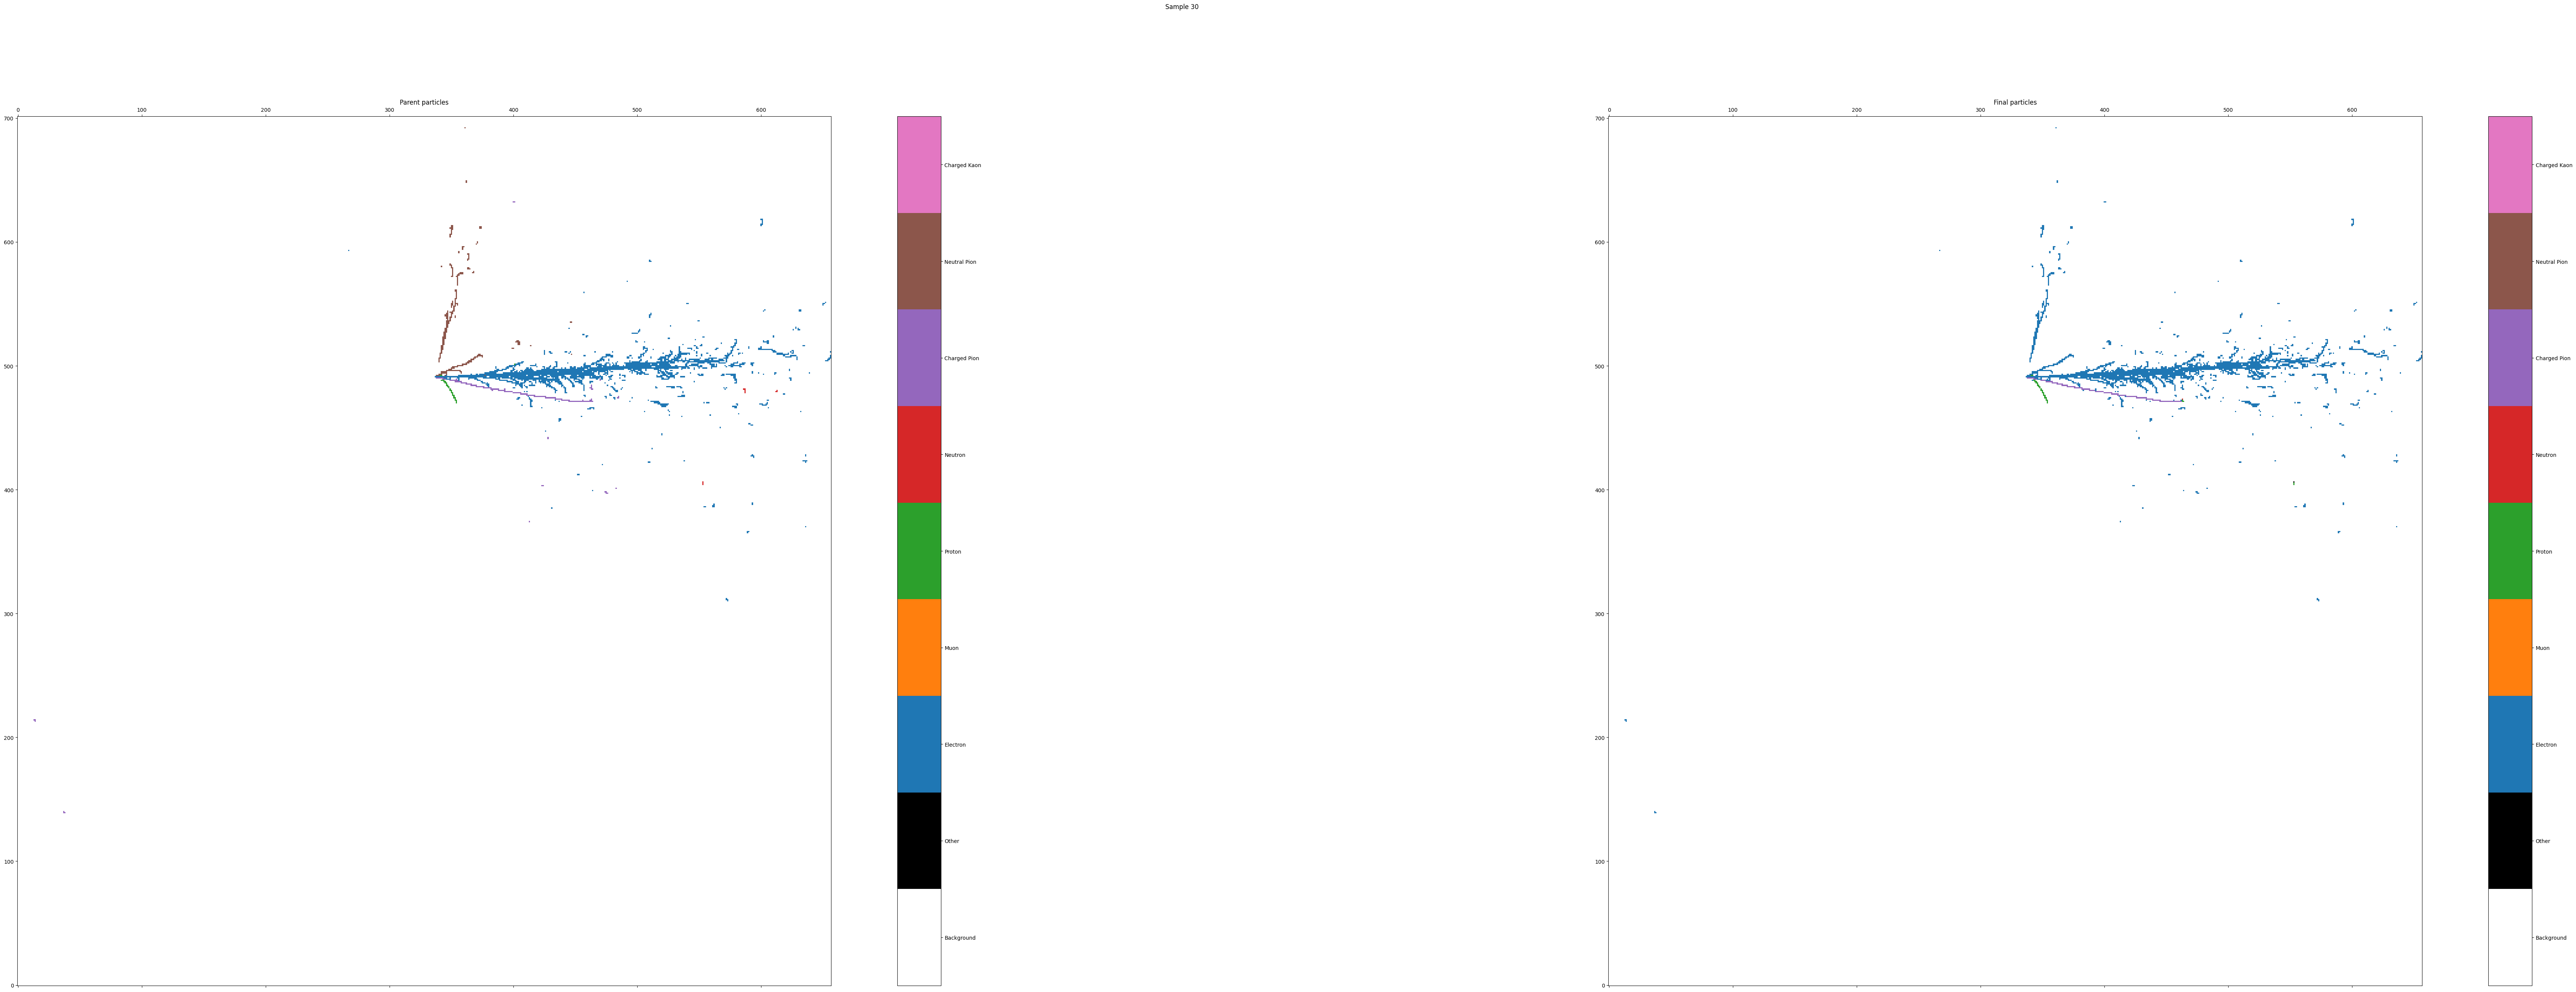

In [6]:
plot_sample(30)